In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

In [13]:
def get_spectogram(mp3_file, n_fft=2205, record_length: None | int = None):
    # if record length exists, load the audio file with the duration, with random start point
    if record_length is not None:
        y, sr = librosa.load(mp3_file, duration=record_length, offset=np.random.randint(0, 30))
    else:
        y, sr = librosa.load(mp3_file)
    
    # encrypt the audio file

    fft_results = librosa.amplitude_to_db(librosa.core.stft(y, n_fft=n_fft))
    
    return fft_results, sr

def create_constellation_map(fft_results, frame_duration=0.1, sr=22050, hop_length=551, mean_coefficient=0.8):
    # Define logarithmic bands
    logarithmic_bands = [(1, 10), (11, 20), (21, 40), (41, 80), (81, 160), (161, 511)]

    frame_length = int(frame_duration * sr / hop_length)
    times = librosa.times_like(fft_results)
    selected_bins_over_time = []

    # Step 2: Find the strongest bin for each band within 0.1-second intervals
    for frame_start in range(0, len(times), frame_length):
        frame_end = frame_start + frame_length
        frame_bins = []
        frame_bin_powers = []

        for start_bin, end_bin in logarithmic_bands:
            max_magnitude = -1
            strongest_bin = None

            for bin_num in range(start_bin, end_bin):
                band_fft = np.abs(fft_results[bin_num, frame_start:frame_end])
                max_magnitude_in_band = np.max(band_fft)

                if max_magnitude_in_band > max_magnitude:
                    max_magnitude = max_magnitude_in_band
                    strongest_bin = bin_num

            frame_bins.append(strongest_bin)
            frame_bin_powers.append(max_magnitude)

        threshold = mean_coefficient * np.mean(frame_bin_powers)
        selected_bins = np.where(np.array(frame_bin_powers) > threshold)[0]
        frame_bins = np.array(frame_bins)[selected_bins]
        
        selected_bins_over_time.append(frame_bins)
        
    constellation_map = []

    for i, frame_bins in enumerate(selected_bins_over_time):
        for bin in frame_bins:
            constellation_map.append(( times[i * frame_length], bin))

    return constellation_map


# plot the graph with bins, then circle the target zones.
def plot_constellation_map(constellation_map, with_indexes=True, duration=None, offset=0):
    _constellation_map = [(time, freq) for time, freq in constellation_map if time >= offset]
    if duration is not None:
        _constellation_map = list(filter(lambda x: x[0] < duration + offset, _constellation_map))
        
    
    plt.figure(figsize=(10, 6))
    plt.scatter([time for time, _ in _constellation_map], [bin for _, bin in _constellation_map], marker='x', color='b')

    if with_indexes:
        for i in range(len(_constellation_map)):
            plt.annotate(str(i), _constellation_map[i])

        
    plt.title('Selected Frequency Bins Over Time (First 1 Seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency Bins')
    plt.show()
    
def find_target_zone_for_anchor(constellation_map, anchor_time, anchor_freq, anchor_index) -> int | None:
    interval = 0
    for i in range(anchor_index + 1, len(constellation_map)):
        time, freq = constellation_map[i]
        if time - anchor_time == 0:
            interval += 1
            continue
        elif interval < 3: 
            interval += 1
            continue
        else:
            return i
    
    return None
    
def create_address_value_couples(constellation_map, song_id: str, zone_size=5):
    addresses_couples = []

    for i, (anchor_time, anchor_freq) in enumerate(constellation_map):
        target_zone_start = find_target_zone_for_anchor(constellation_map, anchor_time, anchor_freq, i)
        if target_zone_start is None:
            break
        
        target_zone_end =  target_zone_start + zone_size if target_zone_start + zone_size < len(constellation_map) else None
        
        if target_zone_end is None:
            break
        
        target_zone = constellation_map[target_zone_start:target_zone_end]

        for time, freq in target_zone:
            address = (anchor_freq, freq, time - anchor_time)
            couple = (anchor_time, song_id)
            addresses_couples.append((address, couple))
            
    
    return addresses_couples

In [14]:
def load_audios(path, num_audios=10):
    audios = {}
    
    paths = os.listdir(path)
    for i, file in enumerate(paths):
        if i == num_audios:
            break
        filename = os.path.splitext(file)[0]
        audio_path = os.path.join(path, file)
        audios[filename] = audio_path
        
    return audios

def create_address_couples(audios: dict):
    addresses_couples = {}
    
    for song_id, audio_path in audios.items():
        fft_results, sr = get_spectogram(audio_path)
        constellation_map = create_constellation_map(fft_results)
        addresses_couples[song_id] = create_address_value_couples(constellation_map, song_id, zone_size=5)
        
    return addresses_couples

def search_address(addresses_couples: dict, addresses: list[tuple]):
    results = {}
    
    for song_id, couples in addresses_couples.items():
        for address, couple in couples:
            if address in addresses:
                if song_id not in results:
                    results[song_id] = []
                results[song_id].append((address, couple))
                
    return results

def print_results(results: list[tuple]):
    for song_id, zones, addresses in results:
        print(f'Song ID: {song_id}, Target Zones: {zones}, Addresses: {addresses}')
        
def get_report(results: list[tuple]):
    unique_couples: dict = {}
    
    for song_id, search in results.items():   
        for address, couple in search:
            if song_id not in unique_couples:
                unique_couples[song_id] = {}
            if couple[0] not in unique_couples[song_id]:
                unique_couples[song_id][couple[0]] = 0
            unique_couples[song_id][couple[0]] += 1
    
    report = []
    for song_id, search in unique_couples.items():
        # count in the search varible that has the 5 as the value
        count_target_zones = sum(value // 5 for value in search.values())
        count_addresses = sum(value for value in search.values())
        report.append((song_id, count_target_zones, count_addresses))
    
    
    # sort the list by the target zones, then by the addresses
    report.sort(key=lambda x: (x[1], x[2]), reverse=True)
    print_results(report[:4])
        
    return report

def search_song(db: dict, target_audio_path: str, target_audio_record_seconds: int = 3):
    fft_results, sr = get_spectogram(target_audio_path, record_length=target_audio_record_seconds)
    constellation_map = create_constellation_map(fft_results)
    song_id = os.path.splitext(os.path.basename(target_audio_path))[0]
    addresses_couples = create_address_value_couples(constellation_map, song_id, zone_size=5)
    addresses = [address for address, _ in addresses_couples]
    results = search_address(db, addresses)
    
    
    
    return constellation_map, results


In [15]:
audios = load_audios('data/fma_small/000/', num_audios=10)
db = create_address_couples(audios)

/var/folders/q8/36kqyvvx5vq9d3tq0f9s_wwh0000gn/T/ipykernel_23922/4113113263.py:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  fft_results = librosa.amplitude_to_db(librosa.core.stft(y, n_fft=n_fft))


In [16]:
for song_id, path in audios.items():
    print(f'Searching {song_id}...')
    _, search_result = search_song(db, path, target_audio_record_seconds=5)
    get_report(search_result)

Searching 000010...


/var/folders/q8/36kqyvvx5vq9d3tq0f9s_wwh0000gn/T/ipykernel_23922/4113113263.py:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  fft_results = librosa.amplitude_to_db(librosa.core.stft(y, n_fft=n_fft))


Song ID: 000010, Target Zones: 364, Addresses: 2095
Song ID: 000825, Target Zones: 18, Addresses: 291
Song ID: 000574, Target Zones: 17, Addresses: 317
Song ID: 000005, Target Zones: 15, Addresses: 352
Searching 000212...
Song ID: 000212, Target Zones: 2, Addresses: 93
Song ID: 000010, Target Zones: 0, Addresses: 49
Song ID: 000005, Target Zones: 0, Addresses: 41
Song ID: 000777, Target Zones: 0, Addresses: 34
Searching 000574...
Song ID: 000574, Target Zones: 189, Addresses: 1231
Song ID: 000993, Target Zones: 62, Addresses: 623
Song ID: 000825, Target Zones: 42, Addresses: 514
Song ID: 000010, Target Zones: 14, Addresses: 295
Searching 000825...
Song ID: 000825, Target Zones: 247, Addresses: 1683
Song ID: 000010, Target Zones: 18, Addresses: 294
Song ID: 000574, Target Zones: 15, Addresses: 354
Song ID: 000993, Target Zones: 12, Addresses: 309
Searching 000602...
Song ID: 000602, Target Zones: 55, Addresses: 632
Song ID: 000207, Target Zones: 1, Addresses: 94
Song ID: 000212, Target 

In [21]:
fft_results, sr = get_spectogram('data/fma_small/000/000010.mp3')
constellation_map_full = create_constellation_map(fft_results)
fft_results, sr = get_spectogram('data/fma_small/000/000010.mp3', record_length=3)
constellation_map_3 = create_constellation_map(fft_results)

/var/folders/q8/36kqyvvx5vq9d3tq0f9s_wwh0000gn/T/ipykernel_23613/3061783006.py:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  fft_results = librosa.amplitude_to_db(librosa.core.stft(y, n_fft=n_fft))


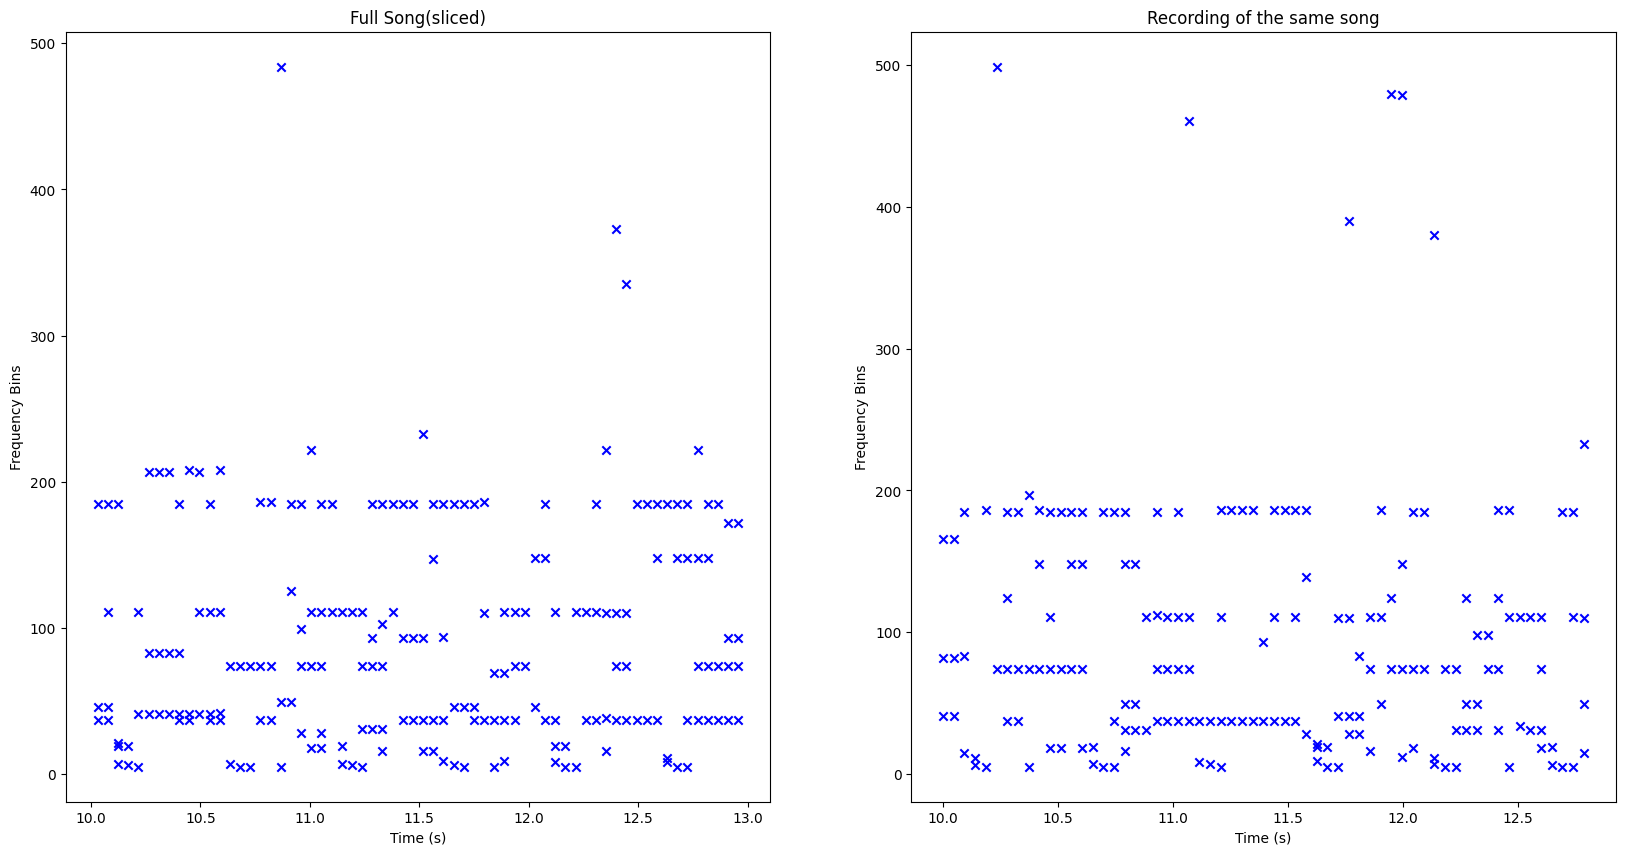

In [22]:
# plot constellation maps side by side. it is formed of (time, frequency) list

constellation_map_sliced = [(time, freq) for time, freq in constellation_map_full if time >= 10 and time <= 13]

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Full Song(sliced)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency Bins')
plt.scatter([time for time, _ in constellation_map_sliced], [bin for _, bin in constellation_map_sliced], marker='x', color='b')

plt.subplot(1, 2, 2)
plt.title('Recording of the same song')
plt.xlabel('Time (s)')
plt.ylabel('Frequency Bins')
plt.scatter([time + 10 for time, _ in constellation_map_3], [bin for _, bin in constellation_map_3], marker='x', color='b')
plt.savefig('constellation_map_2.png')

/var/folders/q8/36kqyvvx5vq9d3tq0f9s_wwh0000gn/T/ipykernel_23613/1508786630.py:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  fft_results = librosa.amplitude_to_db(librosa.core.stft(y, n_fft=n_fft))


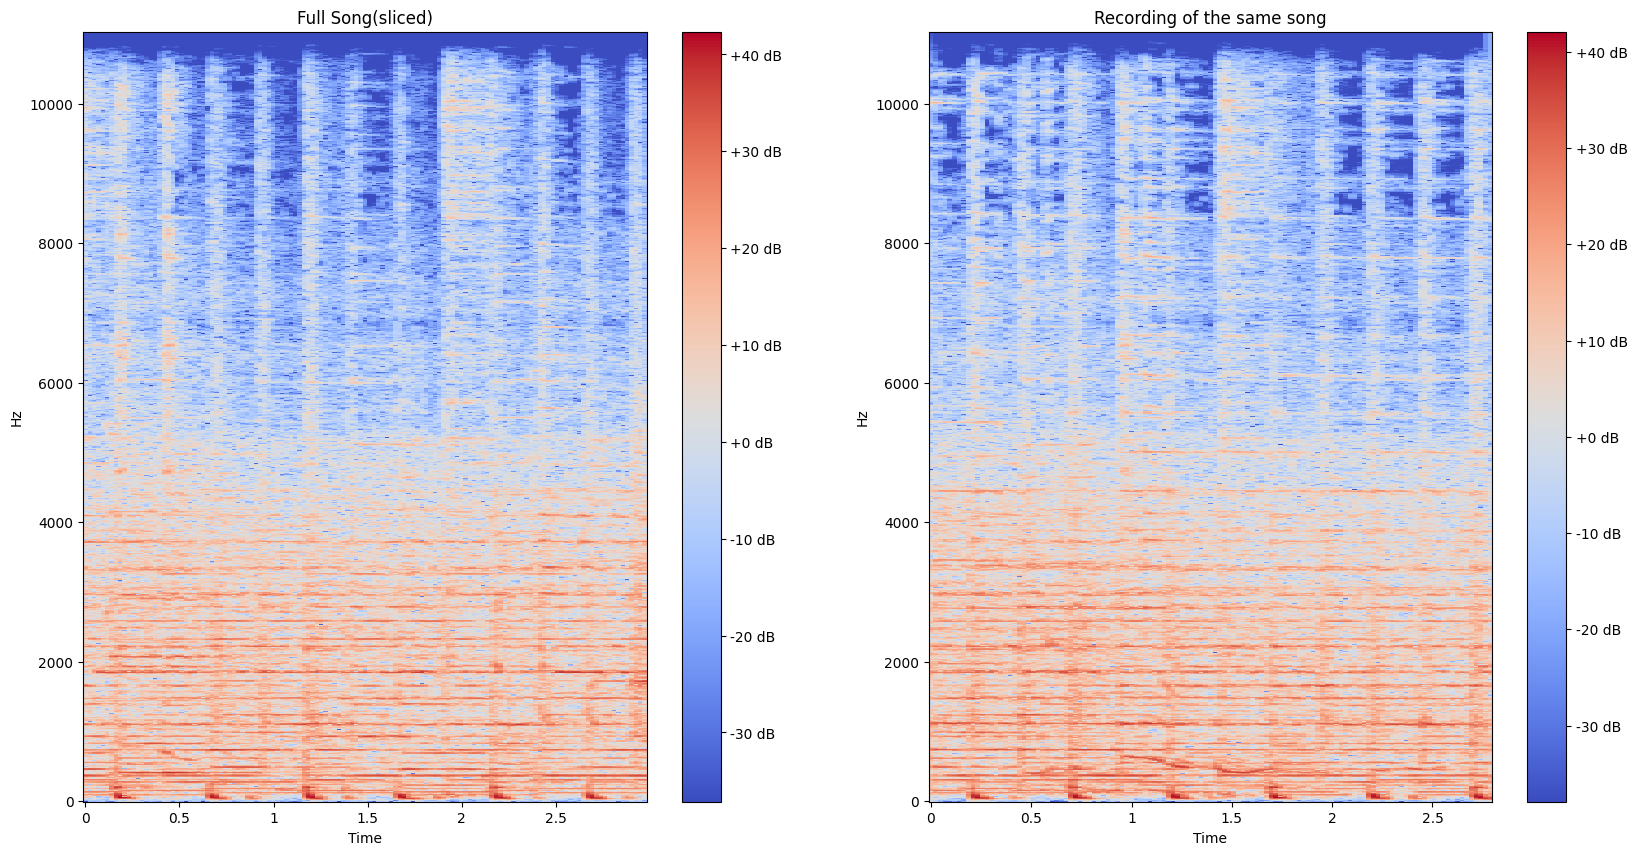

In [16]:
spectogram_3 = get_spectogram('data/fma_small/000/000010.mp3', record_length=3)[0]
spectogram_full = get_spectogram('data/fma_small/000/000010.mp3')[0]
# Define the time range you want to extract from the full spectrogram
start_time = 10.0  # Start time in seconds
end_time = 13.0    # End time in seconds

# Calculate the corresponding indices in the spectrogram
start_index = int(start_time * sr / 512)
end_index = int(end_time * sr / 512)

# Extract the desired portion of the full spectrogram
spectogram_sliced = spectogram_full[:, start_index:end_index]

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Full Song(sliced)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency Bins')
librosa.display.specshow(spectogram_sliced, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
plt.title('Recording of the same song')
plt.xlabel('Time (s)')
plt.ylabel('Frequency Bins')
librosa.display.specshow(spectogram_3, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.savefig('spectogram_2.png')


array([], dtype=float32)